# Solution-1
Analyze the unit cell parameters of proteins and protein-protein complexes in the PDB.

In [1]:
from pyspark import SparkContext
from pyspark.sql import Row, SparkSession
from mmtfPyspark.filters import ContainsLProteinChain
from mmtfPyspark.ml import pythonRDDToDataset
from mmtfPyspark.io import mmtfReader
import matplotlib.pyplot as plt

#### Configure Spark Session and Spark Context

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Solution-1").getOrCreate()
sc = spark.sparkContext

#### Read a  sample of the PDB

In [3]:
path = "/Users/peter/MMTF_Files/full_pisces25_2.2_drugs_10KA"
pdb = mmtfReader.read_sequence_file(path, sc)

### TODO-1 Restrict the analysis to proteins only

In [4]:
pdb = pdb.filter(ContainsLProteinChain())

### Remove structures without unit cell data

In [5]:
pdb = pdb.filter(lambda t: t[1].unit_cell != None)

### TODO-2 Define method to create a Row with unit cell data

In [6]:
def calcProperties(s):
    structure_id = s[0]
    space_group = s[1].space_group
    a, b, c, alpha, beta, gamma = s[1].unit_cell

    return Row(structure_id, space_group, a, b, c, alpha, beta, gamma)

### TODO-3: Map structures to properties

In [7]:
rows = pdb.map(lambda s: calcProperties(s))

### TODO-4: Create a dataset from the RDD

In [8]:
col_names = ["structureId", "spaceGroup", "a", "b", "c", "alpha", "beta", "gamma"]
summary = pythonRDDToDataset.get_dataset(rows, col_names).cache()

## Done: Show some details about this dataset

In [9]:
summary.columns

['structureId', 'spaceGroup', 'a', 'b', 'c', 'alpha', 'beta', 'gamma']

In [10]:
summary.printSchema()

root
 |-- structureId: string (nullable = false)
 |-- spaceGroup: string (nullable = false)
 |-- a: float (nullable = false)
 |-- b: float (nullable = false)
 |-- c: float (nullable = false)
 |-- alpha: float (nullable = false)
 |-- beta: float (nullable = false)
 |-- gamma: float (nullable = false)



In [11]:
summary.toPandas().head(10)

,structureId,spaceGroup,a,b,c,alpha,beta,gamma
0,1LBU,P 1 21 1,51.080002,49.700001,38.650002,90.0,100.599998,90.0
1,1LC0,P 21 21 21,51.779999,75.730003,76.080002,90.0,90.000000,90.0
2,1LC5,I 2 2 2,75.989998,103.339996,109.250000,90.0,90.000000,90.0
3,1LFP,P 21 21 21,43.790001,65.349998,73.779999,90.0,90.000000,90.0
4,1LFW,P 21 21 21,67.151001,77.025002,89.955002,90.0,90.000000,90.0
5,1LGH,P 4 21 2,91.599998,91.599998,209.970001,90.0,90.000000,90.0
6,1LH0,C 2 2 2,105.570000,154.229996,52.599998,90.0,90.000000,90.0
7,1LJ8,I 2 2 2,102.096001,103.188004,106.195999,90.0,90.000000,90.0
8,1LKI,P 21 21 21,31.100000,56.200001,95.300003,90.0,90.000000,90.0
9,1LMI,P 65 2 2,43.129002,43.129002,228.798004,90.0,90.000000,120.0


## Group data by space group and count occurances

In [12]:
df = summary.groupBy("spaceGroup")\
            .count()\
            .sort("count", ascending=False)\
            .toPandas()

df.head(10)

,spaceGroup,count
0,P 21 21 21,2211
1,P 1 21 1,1595
2,C 1 2 1,1076
3,P 21 21 2,558
4,C 2 2 21,544
5,P 1,417
6,P 41 21 2,324
7,P 43 21 2,313
8,P 32 2 1,281
9,P 31 2 1,262


## Plot histogram for the top 10 space groups

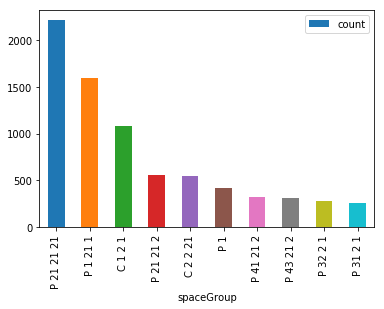

In [13]:
df.head(10).plot(x='spaceGroup', y='count', kind='bar');

In [14]:
spark.stop()